# Tutorial: Extracting Maximum Storage Temperatures for Transistors from PDF Datasheets

## Introduction

In this tutorial, we will walk through the process of using `Fonduer` to identify mentions of transistory polarity (i.e. `NPN` or `PNP`) in a corpus of transistor datasheets from Digikey.com. The tutorial is broken into several parts, each covering a stage in the pipeline:

1. Initialiation
2. Candidate Extraction
3. Annotating Evaluation Data
4. Featurization and Training
5. Evaluation

## Part 1: Initialization

We first preprocess our input documents using `Fonduer` utilities, which transform each richly formatted document into the `Fonduer` unified data model, which captures the variability and multimodality of richly formatted data. We also extract standard linguistic features from each context which will be used later in featurization using [CoreNLP](http://stanfordnlp.github.io/CoreNLP/).

This preprocessed data is saved to a database. Connection strings can be specified by setting the `SNORKELDB` environment variable. If no database is specified, then SQLite at `./snorkel.db` is created by default.

We initialize several variables for convenience that define what the database should be called, what level of parallelization the `Fonduer` pipeline can run with, and the number of documents in our test and training sets. In the code below, we use PostgreSQL as our database backend.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "stg_temp_max"

os.environ['SNORKELDBNAME'] = ATTRIBUTE
os.environ['SNORKELDB'] = 'postgres://localhost:5432/' + os.environ['SNORKELDBNAME']
        
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/')

### Initializing a `SnorkelSession`

We first initialize a `SnorkelSession`, which manages the connection to the database automatically, and enables us to save intermediate results. This code also reinitializes each of the databases to ensure that we are starting fresh.

In [3]:
print os.system("dropdb " + os.environ['SNORKELDBNAME'])
print os.system("createdb " + os.environ['SNORKELDBNAME'])
print "SNORKELDB = %s" % os.environ['SNORKELDB']
print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']

from snorkel import SnorkelSession
session = SnorkelSession()

256
0
SNORKELDB = postgres://localhost:5432/stg_temp_max
SNORKELDBNAME = stg_temp_max


### Parsing and Loading the Corpus

Next, we preprocess and load the corpus of datasheets. Each datasheet has a PDF and HTML representation. Both representations are used in conjunction to create a robust unified data model with textual, structural, tabular, and visual modality information. Note that since each document is independent of each other, we can parse the documents in parallel. **Note that parallel execution will not work with SQLite, the default database engine**. We depend on PostgreSQL for this functionality.

#### Configuring an `HTMLPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the number of documents to parse. For the sake of this tutorial, we only look at 50 documents.

*Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.*

In [4]:
from snorkel.parser import HTMLPreprocessor, OmniParser

docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/dev/html/'
pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/dev/pdf/'

doc_preprocessor = HTMLPreprocessor(docs_path, max_docs=50)

#### Configuring an `OmniParser`
Next, we configure an `OmniParser`, which serves as our `CorpusParser` for PDF documents. We use NLP preprocessing tools to split our documents into phrases, tokens, and provide annotations such as part-of-speech tags and dependency parse structures for these phrases. In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable all modality information.

In [5]:
corpus_parser = OmniParser(structural=True, lingual=True, visual=True, pdf_path=pdf_path)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

Clearing existing...
Running UDF...
CPU times: user 6.37 s, sys: 132 ms, total: 6.5 s
Wall time: 3min 32s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many phrases and tables are contained in each document.

In [6]:
from snorkel.models import Document, Phrase

print "Documents:", session.query(Document).count()
print "Phrases:", session.query(Phrase).count()

Documents: 50
Phrases: 23605


## Part 2: Candidate Extraction

The next step is to extract **candidates** from our corpus. A `candidate` is the objects for which we want to make predictions. In this case, the candidates are pairs of transistor part numbers and their corresponding polarities as found in their datasheets. Our task is to predict which pairs are true in the associated document.

### Defining a `Candidate` schema
We first define the **schema** of the relation we want to extract. This must be a subclass of `Candidate`, and we define it using a helper function. Here, we define a binary relation which connects two `Span` objects of text. This function also created the database table if it does not already exist.

In [7]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Writing a `CandidateExtractor`

Next, we write **matchers** to define which spans of text in the corpus are instances of each entity. In our case, we need to write a matcher that defines a transistor part number and a matcher to define a valid polarity value.

Matchers can leverage a variety of information from regular expressions, to dictionaries, to user-defined functions. Furthermore, different techniques can be combined to form higher quality matchers. In general, matchers should seek to be as precise as possible while maintaining complete recall.

#### Writing an advanced transistor part matcher

Here, we show how transistor part numbers can leverage [naming conventions](https://en.wikipedia.org/wiki/Transistor#Part_numbering_standards.2Fspecifications) as regular expressions, and use a dictionary of known part numbers, and use user-defined functions together. First, we create a regular expression matcher for standard transistor naming conventions.

In [8]:
from snorkel.matchers import *

### Transistor Naming Conventions as Regular Expressions ###
eeca_rgx = '([ABC][A-Z][WXYZ]?[0-9]{3,5}(?:[A-Z]){0,5}[0-9]?[A-Z]?(?:-[A-Z0-9]{1,7})?(?:[-][A-Z0-9]{1,2})?(?:\/DG)?)'
jedec_rgx = '(2N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = '(2S[ABCDEFGHJKMQRSTVZ]{1}[\d]{2,4})'
others_rgx = '((?:NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|ZXT|TIS|TIPL|DTC|MMBT|SMMBT|PZT|FZT|STD|BUV|PBSS|KSC|CXT|FCX|CMPT){1}[\d]{2,4}[A-Z]{0,5}(?:-[A-Z0-9]{0,6})?(?:[-][A-Z0-9]{0,1})?)'

part_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_rgx_matcher = RegexMatchSpan(rgx=part_rgx, longest_match_only=True)


Next, we can create a matcher from a dictionary of known part numbers:

In [9]:
import csv

def get_digikey_parts_set(path):
    """
    Reads in the digikey part dictionary and yeilds each part.
    """
    all_parts = set()
    with open(path, "r") as csvinput:
        reader = csv.reader(csvinput)
        for line in reader:
            (part, url) = line
            all_parts.add(part)
    return all_parts
            
### Dictionary of known transistor parts ###
dict_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/gold_raw/digikey_part_dictionary.csv'
part_dict_matcher = DictionaryMatch(d=get_digikey_parts_set(dict_path))

We can also use user-defined functions to further improve our matchers. For example, here we use patterns in the document filenames as a signal for whether a span of text in a document is a valid transistor part number.

In [10]:
def common_prefix_length_diff(str1, str2):
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return min(len(str1), len(str2)) - i
    return 0

def part_file_name_conditions(attr):
    file_name = attr.sentence.document.name
    if len(file_name.split('_')) != 2: return False
    if attr.get_span()[0] == '-': return False
    name = attr.get_span().replace('-', '')
    return any(char.isdigit() for char in name) and any(char.isalpha() for char in name) and common_prefix_length_diff(file_name.split('_')[1], name) <= 2

add_rgx = '^[A-Z0-9\-]{5,15}$'

part_file_name_lambda_matcher = LambdaFunctionMatch(func=part_file_name_conditions)
part_file_name_matcher = Intersect(RegexMatchSpan(rgx=add_rgx, longest_match_only=True), part_file_name_lambda_matcher)

Then, we can union all of these matchers together to form our final part matcher.

In [11]:
part_matcher = Union(part_rgx_matcher, part_dict_matcher, part_file_name_matcher)

#### Writing a simple polarity  matcher

In contrast, our polarity matcher can be a very simple regular expression since polarity values are either "NPN" or "PNP".

In [12]:
attr_matcher = RegexMatchSpan(rgx=r'(?:[1][5-9]|20)[05]', longest_match_only=False)

These two matchers define each entity in our relation schema.

### Define a relation's `ContextSpaces`

Next, in order to define the "space" of all candidates that are even considered from the document, we need to define a `ContextSpace` for each component of the relation we wish to extract.

In the case of transistor part numbers, the `ContextSpace` can be quite complex due to the need to handle implicit part numbers that are implied in text like "BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. In addition, to handle these, we consider all n-grams up to 3 words long.

In contrast, the `ContextSpace` for polarity values is simple: we only need to look at every word in a document individually.

In [13]:
from hardware_spaces import OmniNgramsPart, OmniNgramsTemp
    
part_ngrams = OmniNgramsPart(parts_by_doc=None, n_max=3)
attr_ngrams = OmniNgramsTemp(n_max=2)

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Trottlers, like matchers, act as hard filters, and should be created to have high precsion while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and polarity are not vertically or horizontally aligned.

In [39]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def stg_temp_throttler((part, attr)):
    return True

throttler = stg_temp_throttler

### Dividing the Corpus into Test and Train

We'll split the documents 40/5/5 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [40]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.8, 0.9)
for i,doc in enumerate(docs):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the "space" of things to consider for each candidate, provided matchers that signal when a valid mention is seen, and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the contexts to extract from, the matchers, and the throttler to use. 

In [41]:
from snorkel.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

%time candidate_extractor.apply(train_docs, split=0)

Clearing existing...
Running UDF...
[========================================] 100%
CPU times: user 15.5 s, sys: 700 ms, total: 16.2 s
Wall time: 28.5 s


Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [42]:
train_cands = session.query(Part_Attr).filter(Part_Attr.split == 0).all()
print "Number of candidates:", len(train_cands)

Number of candidates: 2364


### Repeating for development and test splits
Finally, we rerun the same operation for the other two document divisions: dev and test. For each, we simply load the `Corpus` object and run them through the `CandidateExtractor`.

In [43]:
%%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1)
    print "Number of candidates:", session.query(Part_Attr).filter(Part_Attr.split == i+1).count()

Clearing existing...
Running UDF...
[========================================] 100%
Number of candidates: 137
Clearing existing...
Running UDF...
[========================================] 100%
Number of candidates: 422
CPU times: user 2.81 s, sys: 164 ms, total: 2.97 s
Wall time: 6.03 s


## Part 3: Loading Evaluation Labels

Although one of the main purposes of Snorkel is to enable training of state-of-the-art machine learning models without the burden of hand-labeling training data, it is still critical to have a small amount of labeled data to help us develop & evaluate our application.

In particular, we will generally need two small labeled sets:
* A development set, which can be a subset of our training set, which we use to help guide us when writing labeling functions (see next part of the tutorial)
* A test set which we evaluate our final application performance against. Note that for fair evaluation, you should get someone not involved in development of your application to label the test set, so that it is blind!

Let's load in the dev and test sets that we'll be labeling:

In [44]:
dev_cands = session.query(Part_Attr).filter(Part_Attr.split == 1).all()
print len(dev_cands)

test_cands = session.query(Part_Attr).filter(Part_Attr.split == 2).all()
print len(test_cands)

137
422


### Loading External Evaluation Labels

We have already annotated the dev and test set for this tutorial, and we'll now load it using an externally-defined helper function.

Loading and saving external "gold" labels can be a bit messy, but is often a critical part of development, especially when gold labels are expensive and/or time-consuming to obtain. Snorkel stores all labels that are manually annotated in a **stable** format (called StableLabels), which is somewhat independent from the rest of Snorkel's data model, does not get deleted when you delete the candidates, corpus, or any other objects, and can be recovered even if the rest of the data changes or is deleted.

Our general procedure with external labels is to load them into the StableLabel table, then use Snorkel's helpers to load them into the main data model from there. If interested in example implementation details, please see the script we now load:

In [45]:
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/dev/hardware_dev_gold.csv'
load_hardware_labels(session, Part_Attr, gold_file, ATTRIBUTE ,annotator_name='gold')

Loading 2923 candidate labels
[========================================] 100%
AnnotatorLabels created: 828


## Part 4: Featurization and modeling noisy training labels

In this part of the tutorial, we will write **labeling functions** which express various heuristics, patterns, and [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data.

In the wild, hand-labeled training data is rare and expensive. A common scenario is to have access to tons of unlabeled training data, and have some idea of how to label them programmatically. For example:
* We may be able to think of text patterns that would indicate a part and polarity mention are related, for example the word "polarity" appearing between them.
* We may have access to an external knowledge base that lists some pairs of parts and polarities, and can use these to noisily label some of our mention pairs.
Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which `Fonduer` will help us easily apply.

Using data programming, we can then train machine learning models to learn which features are the most important in classifying candidates.

### Multimodal featurization of `Candidates`

Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. There are two methods that can be used to extract features: `Fonduer`'s optimized PostgreSQL batch extractor, or the default `Snorkel` extractor. We show both options:

#### Extract with `Fonduer`'s optimized Postgres Batch Extractor

In [46]:
# from fonduer.async_annotations import BatchFeatureAnnotator

# featurizer = BatchFeatureAnnotator(Part_Attr)
# %time F_train = featurizer.apply(split=0, parallelism=PARALLEL)
# %time F_dev = featurizer.apply(split=1, parallelism=PARALLEL)
# %time F_test = featurizer.apply(split=2, parallelism=PARALLEL)

#### Extract with default `Snorkel` extractor

In [47]:
from snorkel.annotations import FeatureAnnotator
from snorkel.contrib.fonduer.features.features import get_all_feats

featurizer = FeatureAnnotator(f=get_all_feats)
%time F_train = featurizer.apply(split=0, parallelism=PARALLEL)
%time F_dev = featurizer.apply(split=1, parallelism=PARALLEL)
%time F_test = featurizer.apply(split=2, parallelism=PARALLEL)
# F_train

Clearing existing...
Running UDF...
CPU times: user 5min 27s, sys: 22.5 s, total: 5min 49s
Wall time: 19min 31s
Clearing existing...
Running UDF...
CPU times: user 16.8 s, sys: 1.15 s, total: 18 s
Wall time: 1min 8s
Clearing existing...
Running UDF...
CPU times: user 1min 30s, sys: 6.48 s, total: 1min 36s
Wall time: 5min 13s


#### Using a development set
In our setting here, we will use the phrase "development set" to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions. Unlike the test set, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions.

In our case, we already loaded labels for a development set (split 1), so we can load them again now:

In [48]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<137x1 sparse matrix of type '<type 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

### Creating Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing labeling functions (**LFs**) (as opposed to hand-labeling massive training sets). We'll go through some examples for our spouse extraction task below.

A labeling function isn't anything special. It's just a Python function that accepts a `Candidate` as the input argument and returns `1` if it says the Candidate should be marked as true, `-1` if it says the `Candidate` should be marked as false, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are unipolar: it labels only 1s and 0s, or it labels only -1s and 0s.

Recall that our goal is to ultimately train a high-performance classification model that predicts which of our Candidates are true mentions of spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

In [49]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def LF_storage_row(c):
    return 1 if 'storage' in get_row_ngrams(c.attr) else 0

def LF_operating_row(c):
    return 1 if 'operating' in get_row_ngrams(c.attr) else 0

def LF_temperature_row(c):
    return 1 if 'temperature' in get_row_ngrams(c.attr) else 0

def LF_tstg_row(c):
    return 1 if overlap(
        ['tstg','stg','ts'], 
        list(get_row_ngrams(c.attr))) else 0

def LF_not_temp_relevant(c):
    return -1 if not overlap(
        ['storage','temperature','tstg','stg', 'ts'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_temp_outside_table(c):
    return -1 if not c.attr.is_tabular() is None else 0

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.attr, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 3 else 0

def LF_collector_aligned(c):
    return -1 if overlap(
        ['collector', 'collector-current', 'collector-base', 'collector-emitter'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_current_aligned(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['current', 'dc', 'ic'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_temp(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_part(c):
    ngrams = get_aligned_ngrams(c.part)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_typ_row(c):
    return -1 if overlap(
        ['typ', 'typ.'],
        list(get_row_ngrams(c.attr))) else 0

def LF_test_condition_aligned(c):
    return -1 if overlap(
        ['test', 'condition'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_complement_left_row(c):
    return -1 if (
        overlap(['complement','complementary'], 
        chain.from_iterable([get_row_ngrams(c.part), get_left_ngrams(c.part, window=10)]))) else 0

def LF_temp_on_high_page_num(c):
    return -1 if c.attr.get_attrib_tokens('page')[0] > 2 else 0

def LF_to_left(c):
    return 1 if 'to' in get_left_ngrams(c.attr, window=2) else 0

def LF_negative_number_left(c):
    return 1 if any([re.match(r'-\s*\d+', ngram) for ngram in get_left_ngrams(c.attr, window=4)]) else 0



stg_temp_lfs = [
    LF_storage_row,
    LF_operating_row,
    LF_temperature_row,
    LF_tstg_row,
    LF_not_temp_relevant,
    LF_temp_outside_table,
    LF_too_many_numbers_row,
    LF_collector_aligned,
    LF_current_aligned,
    LF_voltage_row_temp,
    LF_voltage_row_part,
    LF_typ_row,m
    LF_test_condition_aligned,
    LF_complement_left_row,
    LF_temp_on_high_page_num,
    LF_to_left,
    LF_negative_number_left
]

### Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database. We'll do this using the `LabelAnnotator` class, a `UDF` which we will again run with `UDFRunner`. Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set. Also note that we are using `Fonduer`'s optimized batch label annotator, which runs in parallel and depends on having Postgres as the backend database. 

In [50]:
# from fonduer.async_annotations import BatchLabelAnnotator

# labeler = BatchLabelAnnotator(Part_Attr, lfs = polarity_lfs)
# %time L_train = labeler.apply(split=0, parallelism=4)
# L_train

In [51]:
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(f=stg_temp_lfs)
%time L_train = labeler.apply(split=0, parallelism=PARALLEL)
L_train

Clearing existing...
Running UDF...
CPU times: user 7.81 s, sys: 732 ms, total: 8.54 s
Wall time: 1min 55s


<2364x17 sparse matrix of type '<type 'numpy.float64'>'
	with 10071 stored elements in Compressed Sparse Row format>

Note that the returned matrix is a special subclass of the scipy.sparse.csr_matrix class, with some special features which we demonstrate below:

In [52]:
L_train.get_candidate(session, 0)

Part_Attr(ImplicitSpan("2N6426", sentence=8132, words=[0,2], position=[0]), ImplicitSpan("200", sentence=8864, words=[0,0], position=[0]))

We can also view statistics about the resulting label matrix.
* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In [53]:
# %time L_train.lf_stats_legacy()
%time L_train.lf_stats(session, )

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 22.7 ms


,j,Coverage,Overlaps,Conflicts
LF_storage_row,0,0.093486,0.093486,0.093486
LF_operating_row,1,0.046954,0.046954,0.046954
LF_temperature_row,2,0.145093,0.145093,0.145093
LF_tstg_row,3,0.085448,0.085448,0.085448
LF_not_temp_relevant,4,0.851946,0.851946,0.003384
LF_temp_outside_table,5,1.000000,1.000000,0.148900
LF_too_many_numbers_row,6,0.470812,0.470812,0.020305
LF_collector_aligned,7,0.082064,0.082064,0.000000
LF_current_aligned,8,0.347293,0.347293,0.000423
LF_voltage_row_temp,9,0.277919,0.277919,0.012690


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [54]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

CPU times: user 52 s, sys: 16 ms, total: 52 s
Wall time: 52 s


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [55]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

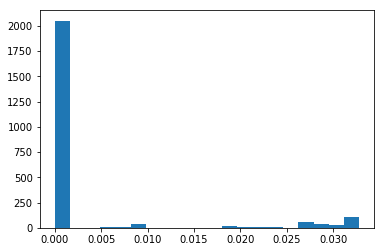

In [56]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [57]:
gen_model.weights.lf_accuracy()

array([ 0.50098373,  0.50991364,  0.48516566,  0.50385501,  0.82912448,
        0.85116051,  0.68835267,  0.55004647,  0.64632101,  0.62061033,
        0.62011074,  0.51869556,  0.52365299,  0.53818502,  0.6355415 ,
        0.50859126,  0.50440776])

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [58]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%


Then, we get the score of the generative model:

In [59]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 107 | FN: 30



### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).

## Part 5: Training our End Extraction Model

Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple - but fairly effective - logistic regression model. More generally, however, Snorkel plugs in with many ML libraries including [TensorFlow](https://www.tensorflow.org/), making it easy to use almost any state-of-the-art model as the end extractor!

### Training the Discriminative Model
We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [60]:
from snorkel.learning import SparseLogisticRegression

disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=2364  #epochs=200  batch size=100
[SparseLR] Epoch 0 (0.48s)	Avg. loss=0.345707	NNZ=9937
[SparseLR] Epoch 5 (3.01s)	Avg. loss=0.034665	NNZ=9937
[SparseLR] Epoch 10 (5.57s)	Avg. loss=0.025609	NNZ=9937
[SparseLR] Epoch 15 (7.98s)	Avg. loss=0.022494	NNZ=9937
[SparseLR] Epoch 20 (10.41s)	Avg. loss=0.020994	NNZ=9937
[SparseLR] Epoch 25 (12.93s)	Avg. loss=0.020129	NNZ=9937
[SparseLR] Epoch 30 (15.42s)	Avg. loss=0.019577	NNZ=9937
[SparseLR] Epoch 35 (17.72s)	Avg. loss=0.019202	NNZ=9937
[SparseLR] Epoch 40 (19.96s)	Avg. loss=0.018935	NNZ=9937
[SparseLR] Epoch 45 (22.05s)	Avg. loss=0.018740	NNZ=9937
[SparseLR] Epoch 50 (24.22s)	Avg. loss=0.018594	NNZ=9937
[SparseLR] Epoch 55 (26.39s)	Avg. loss=0.018481	NNZ=9937
[SparseLR] Epoch 60 (28.48s)	Avg. loss=0.018393	NNZ=9937
[SparseLR] Epoch 65 (31.67s)	Avg. loss=0.018323	NNZ=9937
[SparseLR] Epoch 70 (33.79s)	Avg. loss=0.018267	NNZ=9937
[SparseLR]

### Evaluating on the Test Set
In this final section, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates from earlier:

In [61]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Now, we score using the discriminitive model:

In [62]:
tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 282 | FN: 140



In [63]:
from hardware_utils import entity_level_f1
import os

import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/sandbox/parts_by_doc_dev.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/dev/hardware_dev_gold.csv'
# corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, test_docs, parts_by_doc=None)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | FN: 48

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 50.3 ms
Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | FN: 48

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 60.4 ms


In [65]:
FN

[('STMICROELECTRONICS_STI130051', 'STI13005-1', '150'),
 ('TKCGS00622-1', 'DTC114EE', '150'),
 ('TKCGS00622-1', 'DTC114TE', '150'),
 ('TKCGS00622-1', 'DTC114YE', '150'),
 ('TKCGS00622-1', 'DTC123EE', '150'),
 ('TKCGS00622-1', 'DTC123JE', '150'),
 ('TKCGS00622-1', 'DTC124EE', '150'),
 ('TKCGS00622-1', 'DTC124XE', '150'),
 ('TKCGS00622-1', 'DTC143EE', '150'),
 ('TKCGS00622-1', 'DTC143TE', '150'),
 ('TKCGS00622-1', 'DTC143ZE', '150'),
 ('TKCGS00622-1', 'DTC144EE', '150'),
 ('TTELECTRONICSOPTEKTECHNOLOGY_2N2222AUATXV', '2N2222AUA', '200'),
 ('TTELECTRONICSOPTEKTECHNOLOGY_2N2222AUATXV', '2N2222AUATX', '200'),
 ('TTELECTRONICSOPTEKTECHNOLOGY_2N2222AUATXV', '2N2222AUATXV', '200'),
 ('VISHS23888-1', 'BC546', '150'),
 ('VISHS23888-1', 'BC546A', '150'),
 ('VISHS23888-1', 'BC546B', '150'),
 ('VISHS23888-1', 'BC547', '150'),
 ('VISHS23888-1', 'BC547A', '150'),
 ('VISHS23888-1', 'BC547B', '150'),
 ('VISHS23888-1', 'BC547C', '150'),
 ('VISHS23888-1', 'BC548', '150'),
 ('VISHS23888-1', 'BC548A', '150

In [68]:
fn_cand = fn_list[20]

from hardware_utils import part_error_analysis
part_error_analysis(fn_cand)

Doc: Document ZETXS01948-1
------------
Part:
Span("BC856B-Z3B", sentence=38874, chars=[0,9], words=[0,0])
Phrase (Doc: ZETXS01948-1, Table: 0, Row: 2, Col: 0, Index: 0, Text: BC856B-Z3B)
------------
Attr:
ImplicitSpan("150", sentence=39742, words=[0,0], position=[0])
Phrase (Doc: ZETXS01948-1, Table: 3, Row: 9, Col: 5, Index: 0, Text: 150)
------------
